# Monte Carlo Control

In [21]:
import sys
import random
import gym
import numpy as np
from collections import defaultdict
from plot_utils import plot_blackjack_values, plot_policy

In [22]:
env = gym.make('Blackjack-v1')

In [23]:
def get_probs(Q_s, epsilon, nA):
    """ 
    Get the probability of taking the best known action according to epsilon.
    Returns the policy for the Q value given
    """
    policy_s = np.ones(nA) * epsilon / nA
    best_a = np.argmax(Q_s)
    policy_s[best_a] = 1 - epsilon + (epsilon / nA)
    return policy_s

In [24]:
def best_policy(Q,nA):
    """
    returns the best actions for each Q value in the policy
    """
    return dict((k,np.argmax(v)) for k, v in Q.items())

In [25]:
def update_Q(env, episode, Q, alpha, gamma):
    """
    Calculate the new Q values for the actions taken in the given episode.
    Returns the new Q policy
    """
    
    for s, a, r in episode:
        first_occurence_idx = next(i for i,x in enumerate(episode) if x[0] == s)
        G = sum([x[2]*(gamma**i) for i,x in enumerate(episode[first_occurence_idx:])])
        Q[s][a] = Q[s][a] + alpha*(G - Q[s][a])
    
    return Q

In [26]:
def play_game(env, Q, epsilon, nA):
    """ 
    generates an episode from following the epsilon-greedy policy containing the state, action and reward for 
    each time step in the episode.
    Returns all step information for that episode
    """
    episode = []
    state = env.reset()
    while True:
        if type(state[0]) == tuple:
            state = state[0]
        probs = get_probs(Q[state], epsilon, nA)
        action = np.random.choice(np.arange(nA), p=probs) \
                                    if state in Q else env.action_space.sample()
        next_state, reward, done, _,info = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

In [27]:
def mc_control(env, num_episodes):
    """
    main method. Iterates through episodes updating epsilon after each, retrieves the list of states, actions
    and rewards from the last episode and use them to calculate the updated Q values
    """
    epsilon = 1.0
    eps_min = 0.01
    decay = 0.9999
    alpha = 0.001
    gamma = 1.0
    
    nA = env.action_space.n
    Q = defaultdict(lambda: np.zeros(nA))
    for i_episode in range(1, num_episodes+1):
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        epislon = max(epsilon*decay, eps_min)
        episode = play_game(env, Q, epsilon, nA)
        Q = update_Q(env, episode, Q, alpha, gamma)
    
    policy = best_policy(Q, nA)
    return policy, Q

Episode 500000/500000.

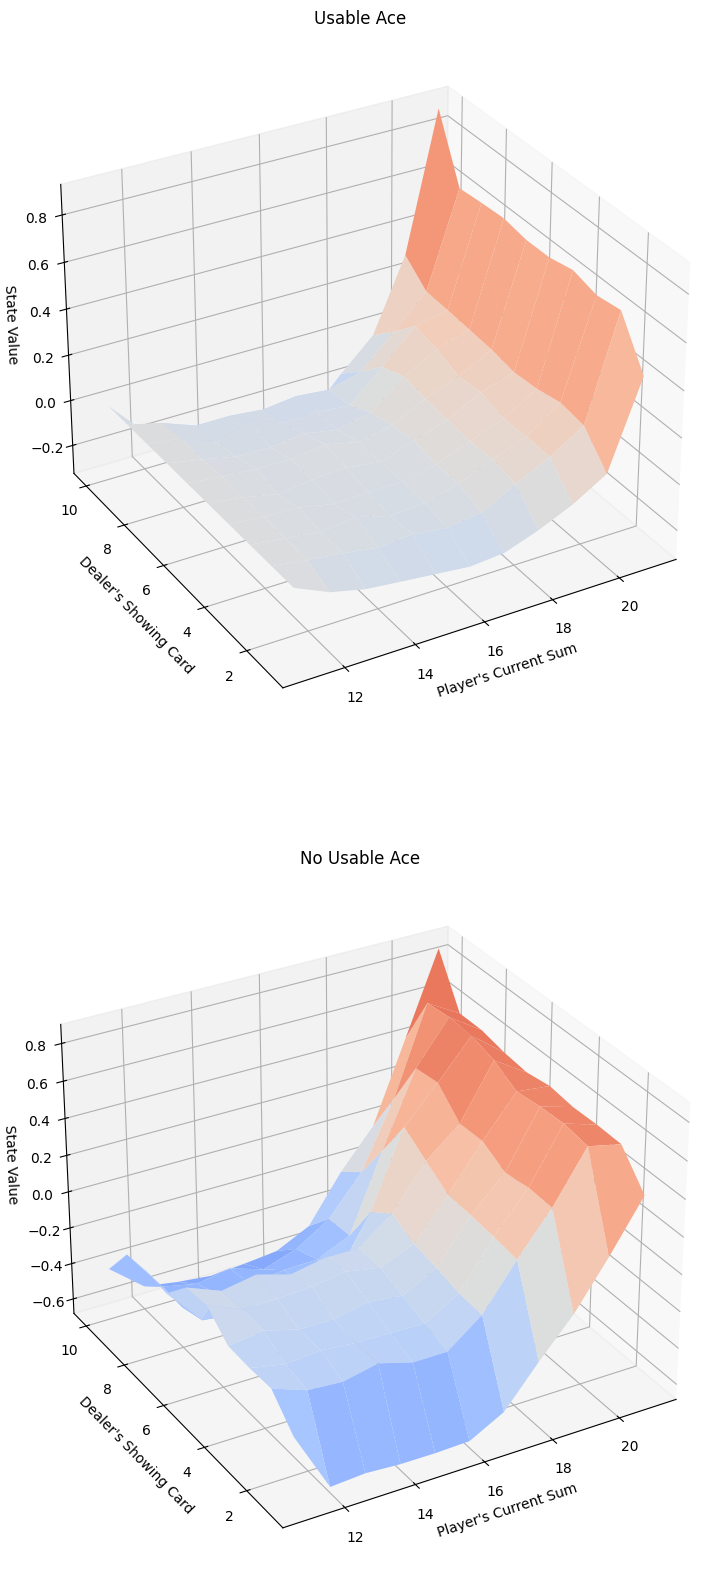

In [28]:
policy, Q = mc_control(env, 500000)
V = dict((k,np.max(v)) for k, v in Q.items())

plot_blackjack_values(V)